<a href="https://colab.research.google.com/github/elisim/piven/blob/master/PIVEN_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick demo of [PIVEN](https://arxiv.org/abs/2006.05139) using keras

In [1]:
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Concatenate, Input
from keras.initializers import RandomNormal, Constant, GlorotNormal
from sklearn.metrics import mean_squared_error

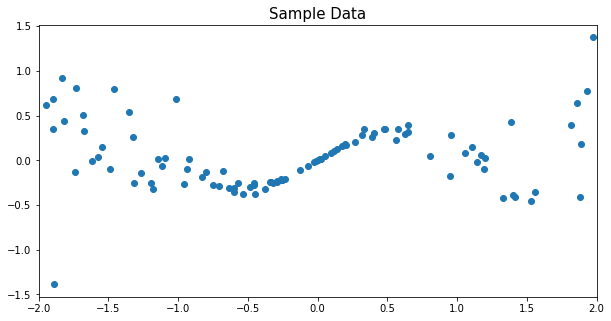

In [2]:
# fix seed
seed = 2
np.random.seed(seed)
tf.random.set_seed(seed)

# create some data
n_samples = 100
X = np.random.uniform(low=-2., high=2., size=(n_samples,1))
y = 1.5*np.sin(np.pi*X[:,0]) + np.random.normal(loc=0.,scale=1*np.power(X[:,0],2))

X_train = X.reshape(-1)
y_train = y.reshape(-1)/5.
y_train = np.stack((y_train,y_train),axis=1) # make this 2d so will be accepted
x_grid = np.linspace(-2,2,100) # for evaluation plots

plt.figure(figsize=(10,5))
plt.scatter(X_train, y_train[:,0])
plt.xlim(-2,2)
plt.title("Sample Data", fontsize=15)
plt.show()

In [3]:
# piven loss definition
def piven_loss(lambda_in=15., soften=160., alpha=0.05, beta=0.5):
    """
    For easy understanding, I referred each equation in the implementation, 
    to the corresponding equation in the article.

    :param lambda_in: lambda parameter 
    :param soften: soften parameter 
    :param alpha: confidence level (1-alpha)
    :param beta: balance parameter 
    """
    def piven_loss(y_true, y_pred):
        # from Figure 1 in the paper
        y_U = y_pred[:, 0] # U(x)
        y_L = y_pred[:, 1] # L(x)
        y_v = y_pred[:, 2] # v(x)
        y_T = y_true[:, 0] # y(x)

        N_ = tf.cast(tf.size(y_T), tf.float32)  # batch size
        alpha_ = tf.constant(alpha)
        lambda_ = tf.constant(lambda_in)

        # k_soft uses sigmoid
        k_soft = tf.multiply(tf.sigmoid((y_U - y_T) * soften), 
                             tf.sigmoid((y_T - y_L) * soften))

        # k_hard uses sign step function
        k_hard = tf.multiply(tf.maximum(0., tf.sign(y_U - y_T)), 
                             tf.maximum(0., tf.sign(y_T - y_L)))

        # MPIW_capt from equation 4
        MPIW_capt = tf.divide(tf.reduce_sum(tf.abs(y_U - y_L) * k_hard),
                              tf.reduce_sum(k_hard) + 0.001)

        # equation 1 where k is k_soft
        PICP_soft = tf.reduce_mean(k_soft) 

        # pi loss from section 4.2
        pi_loss =  MPIW_capt  + lambda_ * tf.sqrt(N_) * tf.square(tf.maximum(0., 1. - alpha_ - PICP_soft))

        y_piven = y_v * y_U + (1 - y_v) * y_L # equation 3 
        y_piven = tf.reshape(y_piven, (-1, 1))

        v_loss = tf.losses.mean_squared_error(y_true, y_piven)  # equation 5
        piven_loss_ = beta * pi_loss + (1-beta) * v_loss # equation 6

        return piven_loss_

    return piven_loss

In [4]:
# build a simple model with one dense layer
inputs = Input(shape=(1,))
dense = Dense(100, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.2, seed=seed), name='dense')(inputs)
pi = Dense(2, activation='linear', kernel_initializer=RandomNormal(mean=0.0, stddev=0.2, seed=seed),
                                   bias_initializer=Constant(value=[3.,-3.]), name='pi')(dense) # pi initialization using bias
v = Dense(1, activation='sigmoid', name='v', kernel_initializer=GlorotNormal(seed=seed))(dense)
piven_out = Concatenate(name='piven_out')([pi, v])
model = Model(inputs=inputs, outputs=[piven_out], name='piven_model')

# compile
opt = keras.optimizers.Adam(lr=0.0009)
model.compile(loss=piven_loss(), optimizer=opt)
model.summary()

Model: "piven_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          200         input_1[0][0]                    
__________________________________________________________________________________________________
pi (Dense)                      (None, 2)            202         dense[0][0]                      
__________________________________________________________________________________________________
v (Dense)                       (None, 1)            101         dense[0][0]                      
________________________________________________________________________________________

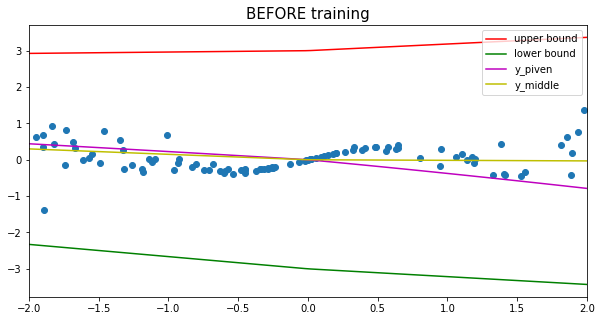

In [5]:
# plot the data with lower and upper bounds before the training
y_pred = model.predict(x_grid, verbose=0)
y_u_pred = y_pred[:, 0]
y_l_pred = y_pred[:, 1]
y_v_pred = y_pred[:, 2]

y_middle = 0.5 * y_u_pred + 0.5 * y_l_pred
y_piven = y_v_pred * y_u_pred + (1 - y_v_pred) * y_l_pred

plt.figure(figsize=(10,5))
plt.scatter(X_train,y_train[:,0])
plt.xlim(-2,2)
plt.plot(x_grid, y_u_pred, color='r', label='upper bound') # U(x) prediction
plt.plot(x_grid, y_l_pred, color='g', label='lower bound') # L(x) prediction
plt.plot(x_grid, y_piven, color='m', label='y_piven') # y_piven
plt.plot(x_grid, y_middle, color='y', label='y_middle') # y_middle
plt.legend(loc='upper right')

plt.title('BEFORE training', fontsize=15)
plt.xlim(-2,2)
plt.show()

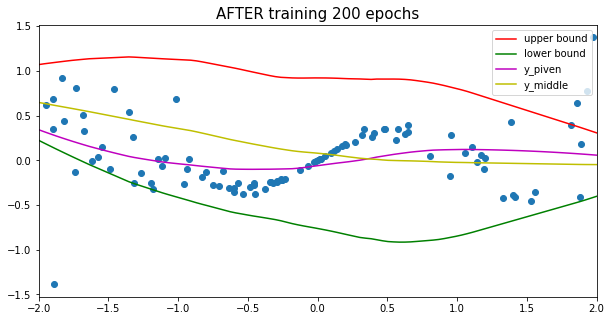

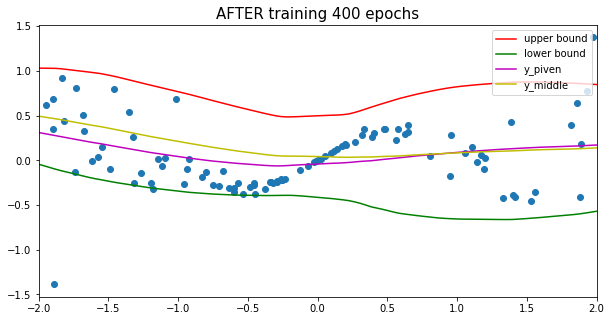

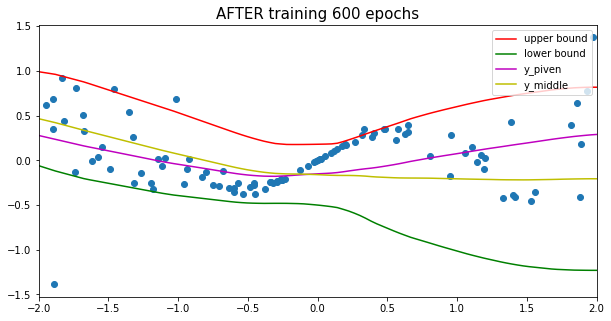

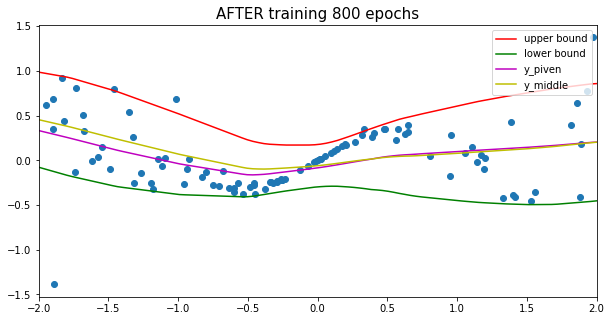

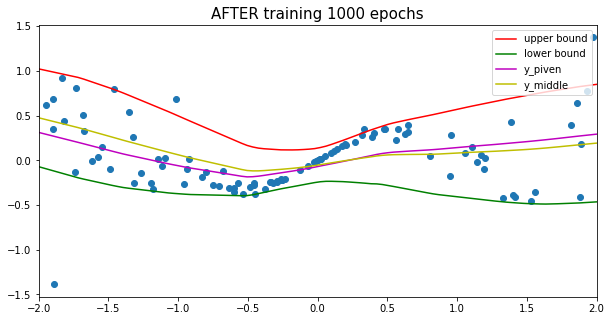

In [6]:
# visualize the training process
loss_history = []
iters = 5
epochs = 200

for i in range(1, iters+1):
    result = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)
    loss_history.append(result.history['loss'])
    
    # plot and view some predictions
    y_pred = model.predict(x_grid, verbose=0)
    y_u_pred = y_pred[:,0]
    y_l_pred = y_pred[:,1]
    y_v_pred = y_pred[:,2]

    y_middle = 0.5 * y_u_pred + 0.5 * y_l_pred
    y_piven = y_v_pred * y_u_pred + (1 - y_v_pred) * y_l_pred
    
    plt.figure(figsize=(10,5))
    plt.scatter(X_train,y_train[:,0])
    plt.xlim(-2,2)
    plt.plot(x_grid, y_u_pred, color='r', label='upper bound') # U(x) prediction
    plt.plot(x_grid, y_l_pred, color='g', label='lower bound') # L(x) prediction
    plt.plot(x_grid, y_piven, color='m', label='y_piven') # y_piven
    plt.plot(x_grid, y_middle, color='y', label='y_middle') # y_middle
    plt.legend(loc='upper right')

    plt.title(f'AFTER training {i*epochs} epochs', fontsize=15)
    plt.show()

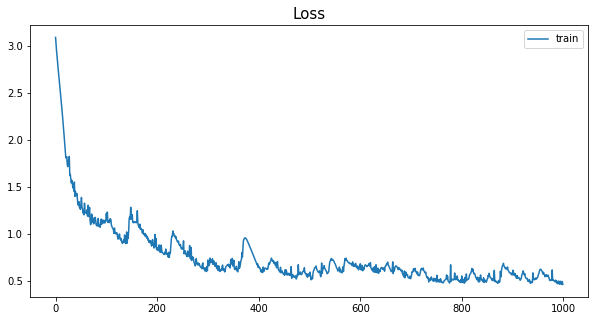

In [7]:
# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10,5))
plt.plot(x, loss_history, label='train')
plt.title('Loss', fontsize=15)
plt.legend(loc='upper right')
plt.show()

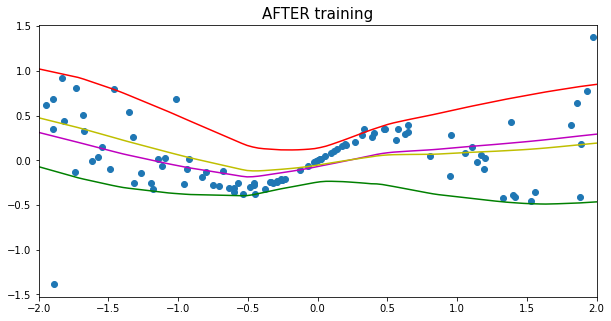

In [8]:
y_pred = model.predict(x_grid, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]
y_v_pred = y_pred[:,2]

y_middle = 0.5 * y_u_pred + 0.5 * y_l_pred
y_piven = y_v_pred * y_u_pred + (1 - y_v_pred) * y_l_pred
    
plt.figure(figsize=(10,5))
plt.scatter(X_train,y_train[:,0])
plt.xlim(-2,2)
plt.plot(x_grid, y_u_pred, color='r', label='upper bound') # U(x) prediction
plt.plot(x_grid, y_l_pred, color='g', label='lower bound') # L(x) prediction
plt.plot(x_grid, y_piven, color='m', label='y_piven') # y_piven
plt.plot(x_grid, y_middle, color='y', label='y_middle') # y_middle

plt.title('AFTER training', fontsize=15)
plt.show()

In [9]:
# print metrics
y_pred = model.predict(X_train, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]

K_u = y_u_pred > y_train[:,0]
K_l = y_l_pred < y_train[:,0]
PICP = np.mean(K_u * K_l)
MPIW = round(np.mean(y_u_pred - y_l_pred), 3)

print('PICP:', PICP)
print('MPIW:', MPIW)

PICP: 0.96
MPIW: 0.802


In [10]:
# compare y_piven and y_middle MSE
y_train_0 = y_train[:, 0]
mse_piven = mean_squared_error(y_train_0, y_piven)
mse_middle = mean_squared_error(y_train_0, y_middle)
improve_pct = ((mse_middle - mse_piven) / mse_middle) * 100

print("y_piven MSE:", round(mse_piven, 3))
print("y_middle MSE:", round(mse_middle, 3))
print("% MSE improvement:", int(round(improve_pct)))

y_piven MSE: 0.161
y_middle MSE: 0.165
% MSE improvement: 3
